In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Młody\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
EPOCHS = 100
BATCH_SIZE = 32

In [30]:
data = pd.read_csv("./news.csv")
len(data)

6335

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [32]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [33]:
# label FAKE == 0 not true 
# label REAL == 1 true
data['label'][data["label"] == "FAKE"] = 0
data['label'][data["label"] == "REAL"] = 1

C:\Users\Młody\AppData\Local\Temp\ipykernel_20444\3025127627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'][data["label"] == "FAKE"] = 0
C:\Users\Młody\AppData\Local\Temp\ipykernel_20444\3025127627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'][data["label"] == "REAL"] = 1


In [34]:
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


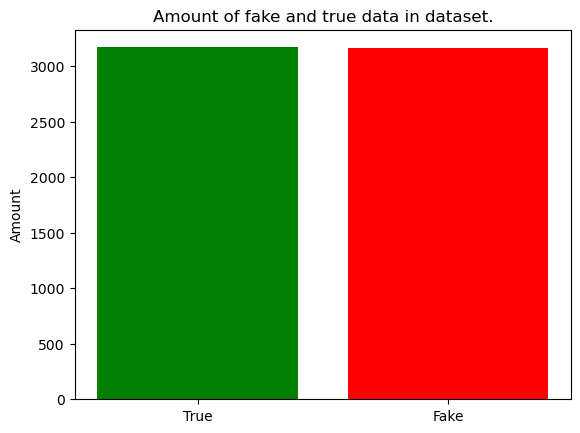

In [35]:
fig, ax = plt.subplots()

labels = ["True", "Fake"]
counts = [len(data['label'][data["label"] == 1]), len(data['label'][data["label"] == 0])]

ax.bar(labels, counts, color=["green", "red"])

ax.set_title("Amount of fake and true data in dataset.")
ax.set_ylabel("Amount")
plt.show()

In [36]:
def prepare_data(data):
    stpwords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    for i in range(len(data)):
        prepared_text = " ".join([lemmatizer.lemmatize(word.lower()) for word in data.iloc[i]['text'].split(" ") if word not in stpwords])
        prepared_title = " ".join([lemmatizer.lemmatize(word.lower()) for word in data.iloc[i]['title'].split(" ") if word not in stpwords])
        data.at[i, 'doc'] = prepared_title + prepared_text
        # data.at[i, 'text'] = prepared_text
        # data.at[i, 'title'] = prepared_title
        print(i)

prepare_data(data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [37]:
X, y = data.drop(["label", 'text', 'title'], axis=1), data['label']
X.head(), y.head()

(   Unnamed: 0                                                doc
 0        8476  you can smell hillary’s feardaniel greenfield,...
 1       10294  watch the exact moment paul ryan committed pol...
 2        3608  kerry go paris gesture sympathyu.s. secretary ...
 3       10142  bernie supporter twitter erupt anger dnc: 'we ...
 4         875  the battle new york: why this primary matterit...,
 0    0
 1    0
 2    1
 3    0
 4    1
 Name: label, dtype: object)

In [38]:
X.drop("Unnamed: 0", axis=1, inplace=True)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train = X_train["doc"].tolist()
X_test = X_test["doc"].tolist()

In [40]:
vectorizer = TfidfVectorizer(max_features=7000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [41]:
class Dataset(Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = np.array(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [42]:
training_set = Dataset(X_train, Y_train)
valid_set = Dataset(X_test, Y_test)
training_iterator = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
X = next(iter(training_iterator))

In [44]:
X[0].dtype

torch.float64

In [45]:
class PredictionModel(nn.Module):
    def __init__(self):
        super(PredictionModel, self).__init__()
        self.md = nn.Sequential(
            nn.Linear(7000, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.to(torch.double)

        return self.md(x)

In [46]:
model = PredictionModel()
model.double()
model.to(device)

PredictionModel(
  (md): Sequential(
    (0): Linear(in_features=7000, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=16, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [47]:
model_dtype = next(model.parameters()).dtype
print(f"Model Data Type: {model_dtype}")

Model Data Type: torch.float64


In [48]:
output = model(X[0].to(device))
output

tensor([[0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237],
        [0.4237]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)

In [49]:
model_optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

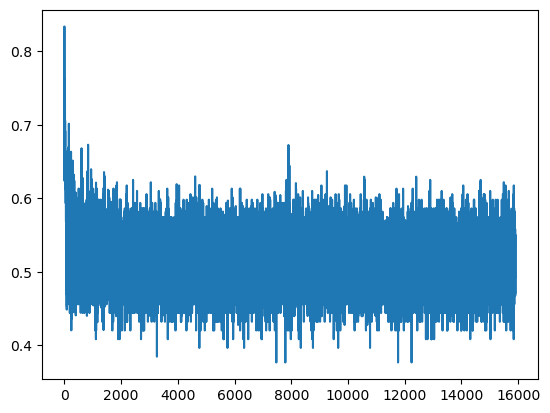

Epoch [100/99], 0.47154730961894054


In [50]:
from IPython.display import clear_output
training_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    model.train()
    
    for input, labels in tqdm(training_iterator):
        labels = labels.unsqueeze(1).to(torch.double).to(device)
        model_optimizer.zero_grad()
        outputs = model(input.to(device))
        loss = criterion(outputs, labels.to(torch.double))
        loss.backward()
        
        training_losses.append(loss.item())
        

        model_optimizer.step()
    
    clear_output(wait=True)
    plt.plot(training_losses)
    plt.show()
    print(f'Epoch [{epoch+1}/{epoch}], {loss.item()}')
    if loss.item() < 0.25:
        break
    

In [65]:
total_correct = 0
total = 0
for inp, labels in valid_iterator:
    total += len(labels)
    output = model(inp.to(device))
    outs = [1 if x >= 0.5 else 0 for x in output]
    for i in range(len(outs)):
        if outs[i] == labels[i]:
            total_correct += 1

print(f"Model accuracy: {total_correct/len(labels):.2f}%")

Model accuracy: 61.26%


In [67]:
torch.save(model.state_dict(), "./model.h5")